In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
# import PIL
import tensorflow as tf
import tensorflow_probability as tfp
# import tensorflow.contrib as tf_contrib
import time

#imp
tf.keras.backend.set_image_data_format('channels_last')

In [2]:
### A simplified attention block
def hw_flatten(x) :
    # return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])
    return tf.reshape(x, shape=(x.shape[0], -1, x.shape[-1]))

def attention(x, channels=265):

    f = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', use_bias=True)(x) # [bs, h, w, c']
    g = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', use_bias=True)(x) # [bs, h, w, c']
    h = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', use_bias=True)(x) # [bs, h, w, c]
    # print('h', h.shape)
    # N = h * w
    # s = tf.linalg.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True) # # [bs, N, N]
    s = tf.matmul(g, f, transpose_b=True) # # [bs, N, N]
    # s = tf.matmul(tf.keras.layers.Flatten()(g), tf.keras.layers.Flatten()(f), transpose_b=True) # # [bs, N, N]
    # print('s', s.shape)
    beta = tf.nn.softmax(s)  # attention map
    # print('beta', beta.shape)

    # o = tf.linalg.matmul(beta, hw_flatten(h)) # [bs, N, C]
    o = tf.matmul(beta, h) # [bs, N, C]
    # o = tf.linalg.matmul(beta, tf.keras.layers.Flatten()(h)) # [bs, N, C]
    # print('o', o.shape)
    # Unsure if this is correct, see documentation: https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable#migrate-to-tf2
    gamma = tf.compat.v1.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

    # o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
    o = tf.keras.layers.Conv2D(filters=channels, kernel_size=1, strides=1, padding='same', use_bias=True)(o)

    x = gamma * o + x

    return x

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # this formula is considered best practice


In [3]:
def Conv3D_Block(inp_shape, conv_filters, batch_normalization, no_of_neurons):
        '''
        
        inp_shape - tuple - (depth, no_of_bins, no_of_bins, channels) - eg. (6,16,16,1) - 6 hours of travel demand map of city divided into 16x16 grid.
        conv_filters - list - [] - no. of filters for the convolutional block, len(conv_filters) determines the depth of the convolutional layers
        batch_normalization - bool - set it to 'True' if you want batch_normalization in the model
        no_of_neurons - list - [] - no of neurons in the dense layers - len(no_of_neurons) determines the depth of the fully connected layers.

        '''
        x = tf.keras.layers.Input(shape=inp_shape)
        inp = x

        for i in range(0,len(conv_filters)):
                x = tf.keras.layers.ConvLSTM2D(filters=conv_filters[i], kernel_size=(3), strides=(2,2), padding="same", return_sequences=True, activation="relu", data_format='channels_last', )(x)
                if batch_normalization:
                        x = tf.keras.layers.BatchNormalization()(x)

        # We will construct 4 `ConvLSTM2D` layers with batch normalization,
        # followed by a `Conv3D` layer for the spatiotemporal outputs.

        res1 = tf.keras.layers.Conv3D(filters=1, kernel_size=(1,1,1), padding="same")(x)
        res1 = tf.keras.layers.LeakyReLU(alpha=0.05)(res1)
        res1 = tf.keras.layers.MaxPooling3D(pool_size=2, )(res1)

        if batch_normalization:
                res1 = tf.keras.layers.BatchNormalization()(res1)
        
        # attention
        x = attention(res1, channels=265)
        
        # residual
        x = tf.keras.layers.Add()([res1, x])

        for i in range(0, len(no_of_neurons)):
                x = tf.keras.layers.Dense(no_of_neurons[i],activation='relu')(x)
                x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)

        # Next, we will build the complete model and compile it.
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model

In [4]:
def encoder_model(inp_shape, conv_filters, batch_normalization,  latent_dim, no_of_neurons):
    """ 
    Adapted from Laurence Moroney's Coursera course on VAEs: https://www.coursera.org/lecture/generative-deep-learning-with-tensorflow/sampling-layer-and-encoder-G2mJr
    
    inp_shape - list of tuples - [(depth, no_of_bins, no_of_bins, channels), .., ...,] - eg. [(6,16,16,1), (), ..] - list of input dimensions of each st_maps.
    conv_filters - list - [] - no. of filters for the convolutional block, len(conv_filters) determines the depth of the convolutional layers
    batch_normalization - bool - set it to 'True' if you want batch_normalization in the model
    latent_dim - int - dimension of latent space
    no_of_neurons - list - [] - no of neurons in the dense layers - len(no_of_neurons) determines the depth of the fully connected layers.
    
    """
    maps = []
    for i in range(0, len(inp_shape)):
        maps.append(Conv3D_Block(inp_shape=inp_shape[i], conv_filters=conv_filters, batch_normalization=batch_normalization, no_of_neurons=no_of_neurons))
        

    x = tf.keras.layers.concatenate(list(map(lambda j:j.output, maps)), axis=-1)
    
    for i in range(0, len(no_of_neurons)):
        x = tf.keras.layers.Dense(no_of_neurons[0],activation='relu')(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
        
    # x = tf.keras.layers.Dense(16, activation='relu')(combined)
    # x = tf.keras.layers.Dense(32, activation='relu')(x)
    # x = tf.keras.layers.Dense(64, activation='relu')(x)

    x = tf.keras.layers.Flatten()(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()([z_mean, z_log_var])

    encoder = tf.keras.Model(inputs=list(map(lambda j:j.input, maps)), outputs=[z_mean, z_log_var, z], name="encoder")
    
    return encoder

In [5]:
def generator_model(latent_dim, target_shape, up_sampling_filters, output_map_shape):
    
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(np.prod(target_shape), activation='relu')(latent_inputs)
    x = tf.keras.layers.Reshape(target_shape=(target_shape[0],target_shape[1],target_shape[2]))(x)

    for i in range(0, len(up_sampling_filters)):
        x = tf.keras.layers.Conv2DTranspose(filters=up_sampling_filters[i], kernel_size=(3), strides=2, padding="same", activation="relu")(x)

    x = tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    x = tf.keras.layers.Reshape(target_shape=output_map_shape)(x)
    x = tf.keras.layers.Conv3DTranspose(filters=1, kernel_size=(3), padding="same", activation="relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
    
    # x = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3), strides=2, padding="same", activation="relu")(x)
    # x = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(3), strides=2, padding="same", activation="relu")(x)
    # x = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1)(x)
    

    #generator = tf.keras.Model(latent_inputs, outputs=[x_real, x_enc, x_fake], name="generator")
    generator = tf.keras.Model(latent_inputs, outputs=x, name="generator")
    return generator

In [6]:
class CVAE(tf.keras.Model):
    def __init__(self, encoder, generator, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.generator = generator
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return[self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_variance, z = self.encoder([inputs[0], inputs[1], inputs[2]])
        reconstruction = self.generator(z)
        return reconstruction


    @tf.function
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_variance, z = self.encoder([data[0], data[1], data[2]])
            reconstruction = self.generator(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_variance - tf.square(z_mean) - tf.exp(z_log_variance))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss =reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return { 
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }


Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [7]:
latent_dim = 4
batch_size = 1 # Paper: 32
channel = 1
taxi_height = 16
taxi_width = 16
bike_height = 16
bike_width = 16
weather_height = 16
weather_width = 16
depth = 6
inp_shape = [(depth, taxi_height, taxi_width, channel), (depth, bike_height, bike_width, channel), (depth, weather_height, bike_width, channel)]

no_of_conv_filters = [16, 32, 64]

no_of_neurons_mlp = [16, 32, 64]

target_shape = [2, 2, 64,]

encoder = encoder_model(inp_shape, no_of_conv_filters, True,  latent_dim, no_of_neurons_mlp)

generator = generator_model(latent_dim, target_shape , no_of_conv_filters, (1,taxi_height,taxi_width,channel))
vae = CVAE(encoder, generator)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [8]:
taxi_data = tf.random.normal(shape = (batch_size,depth, taxi_height, taxi_width, channel))
bike_data = tf.random.normal(shape = (batch_size,depth, bike_height, bike_width, channel))
weather_data = tf.random.normal(shape = (batch_size,depth, bike_height, bike_width, channel))

In [9]:
data = tf.stack([taxi_data, bike_data, weather_data], axis = 0)

In [10]:
vae.fit(data, epochs=1)

1/1 [==============================] - 17s 17s/step - loss: 15.3869 - reconstruction_loss: 15.3869 - kl_loss: 8.1658e-06


In [11]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
print('TensorFlow:', tf.__version__)



forward_pass = tf.function(
    vae.call,
    input_signature=[tf.TensorSpec(shape=data.shape)])

graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = graph_info.total_float_ops // 2
print('Flops: {:,}'.format(flops))

TensorFlow: 2.10.0
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Flops: 9,245,810


In [12]:
vae.build(data.shape)

In [13]:
# implement callbacks, early stopping

In [14]:
9245810 * 3


27737430

In [15]:
import visualkeras
from PIL import ImageFont

In [16]:

model = visualkeras.layered_view(generator).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

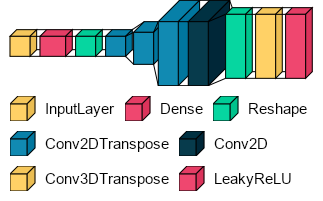

In [17]:
font = ImageFont.truetype("arial.ttf", 15)  # using comic sans is strictly prohibited!
visualkeras.layered_view(generator, legend=True, font=font)  # font is optional!

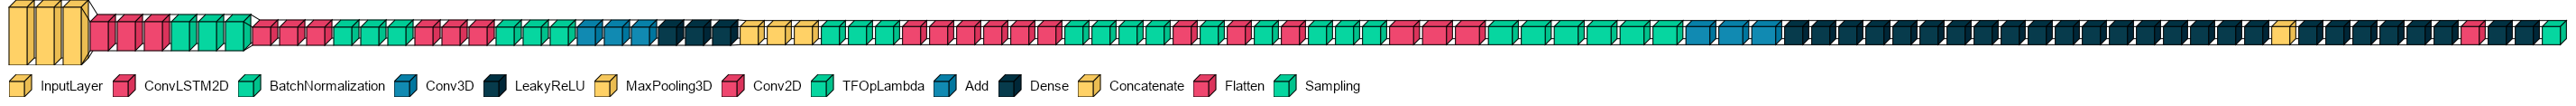

In [18]:
font = ImageFont.truetype("arial.ttf", 15)  # using comic sans is strictly prohibited!
visualkeras.layered_view(encoder, legend=True, font=font) 

In [20]:
encoder.save('saved_model/encoder')

INFO:tensorflow:Assets written to: saved_model/encoder\assets


INFO:tensorflow:Assets written to: saved_model/encoder\assets
